# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Шаг 1. Откройте файлы с данными

In [1]:
pip install category_encoders

     |████████████████████████████████| 81 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools

from category_encoders.target_encoder import TargetEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import  recall_score
from sklearn.metrics import precision_score

from sklearn.model_selection import cross_val_score 
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [3]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv')
hotel_test = pd.read_csv('/datasets/hotel_test.csv')

информация о данных в датасетах

In [4]:
print(hotel_train.info())
print(hotel_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

общие характеристики и проверка на наличие выбивающихся значений

In [5]:
display(hotel_train.describe())

display(hotel_test.describe())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


In [6]:
print(hotel_train.isna().sum())
print(hotel_test.isna().sum())

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64
id                                0
is_canceled                       0
lead_time      

явные дубликаты в датасетах

пропуски в датасетах

In [7]:
print(hotel_train.duplicated().sum())
print(hotel_test.duplicated().sum())

0
0


удалаяем столбец id

In [8]:
hotel_train=hotel_train.drop(['id'], axis=1)
hotel_test=hotel_test.drop(['id'],axis=1)

смотрим явные дубликаты в датасетах после удаления id

In [9]:
print(hotel_train.duplicated().sum())
print(hotel_test.duplicated().sum())

21377
7717


удаляем явные дубликаты

In [10]:
hotel_train=hotel_train.drop_duplicates()
hotel_test=hotel_test.drop_duplicates()
print(hotel_train.duplicated().sum())
print(hotel_test.duplicated().sum())

0
0


проверка на наличие корреляций

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
is_canceled,1.00,0.18,0.06,0.02,0.02,0.04,0.07,0.06,0.04,-0.02,-0.06,0.08,-0.04,-0.08,0.00,-0.17,-0.13,0.07
lead_time,0.18,1.00,0.10,0.10,0.02,0.20,0.32,0.14,0.01,-0.00,-0.13,0.04,-0.07,0.09,0.16,-0.07,0.02,0.34
arrival_date_year,0.06,0.10,1.00,-0.36,-0.00,-0.02,-0.04,0.05,0.03,-0.02,0.02,-0.06,0.04,0.01,0.00,-0.02,0.01,-0.04
arrival_date_week_number,0.02,0.10,-0.36,1.00,0.09,0.03,0.04,0.00,-0.00,0.01,-0.02,-0.01,-0.01,0.02,-0.02,-0.01,0.10,0.04
arrival_date_day_of_month,0.02,0.02,-0.00,0.09,1.00,-0.00,-0.00,0.01,0.02,-0.00,-0.01,-0.01,-0.00,0.02,-0.00,0.00,-0.00,-0.00
stays_in_weekend_nights,0.04,0.20,-0.02,0.03,-0.00,1.00,0.26,0.12,0.01,0.02,-0.10,-0.01,-0.04,0.01,-0.04,-0.04,0.05,0.66
stays_in_week_nights,0.07,0.32,-0.04,0.04,-0.00,0.26,1.00,0.14,0.01,0.02,-0.12,-0.01,-0.06,0.05,0.02,-0.05,0.06,0.89
adults,0.06,0.14,0.05,0.00,0.01,0.12,0.14,1.00,-0.02,0.02,-0.21,-0.04,-0.14,-0.05,-0.02,0.01,0.18,0.17
children,0.04,0.01,0.03,-0.00,0.02,0.01,0.01,-0.02,1.00,0.01,-0.04,-0.02,-0.02,0.04,-0.02,0.03,0.08,0.01
babies,-0.02,-0.00,-0.02,0.01,-0.00,0.02,0.02,0.02,0.01,1.00,-0.02,-0.01,-0.01,0.08,-0.01,0.02,0.10,0.02


<AxesSubplot:>

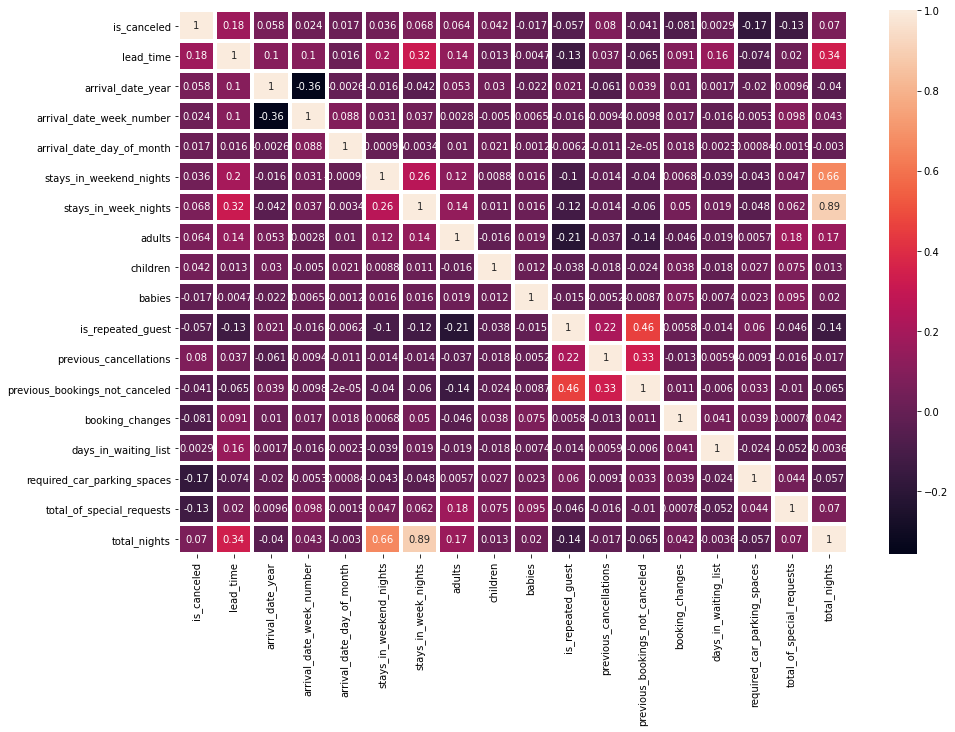

In [11]:
display(hotel_train.corr().round(2))
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(hotel_train.corr(), annot=True, linewidths=3, linecolor='white')

уникальные значения и их количество в столбце отмена заказа

Text(0.5, 1.0, 'Отмена заказа')

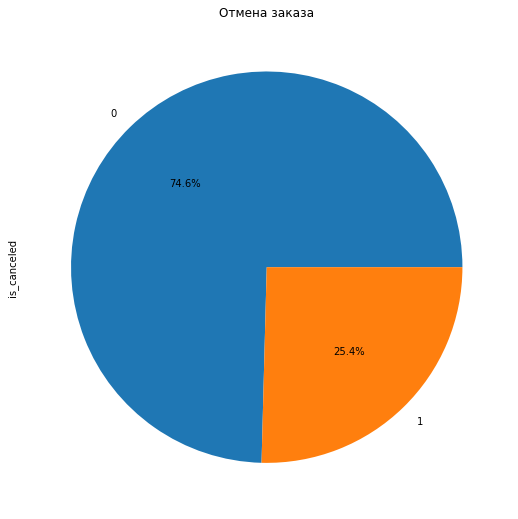

In [12]:
hotel_train['is_canceled'].value_counts() 
hotel_train['is_canceled'].value_counts().plot(kind='pie', figsize=(9, 9), autopct='%1.1f%%')
plt.title('Отмена заказа')

уникальные значения и их количество в столбце месяц заезда

October      5514
September    5212
August       4725
December     4135
November     4099
July         4016
March        3247
April        3219
May          3086
June         2828
February     2300
January      1471
Name: arrival_date_month, dtype: int64


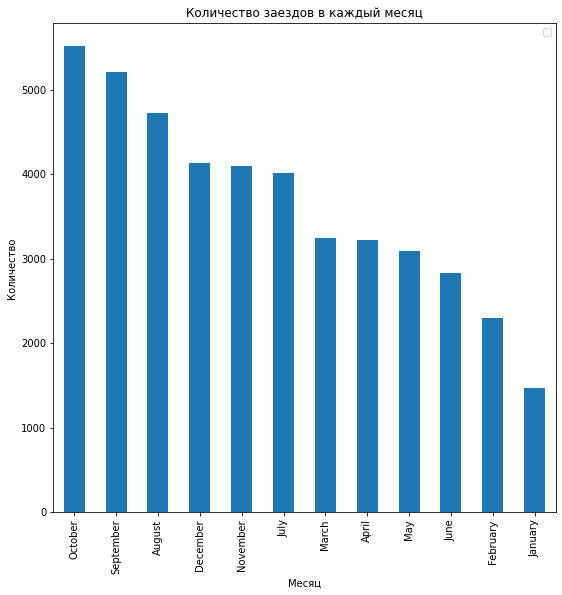

In [13]:
print(hotel_train['arrival_date_month'].value_counts())
hotel_train['arrival_date_month'].value_counts().plot(kind='bar', figsize=(9, 9))
plt.title('Количество заездов в каждый месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.legend([])

уникальные значения и их количество в столбце тип забронированной комнаты

Text(0.5, 1.0, 'Тип забронированных комнат')

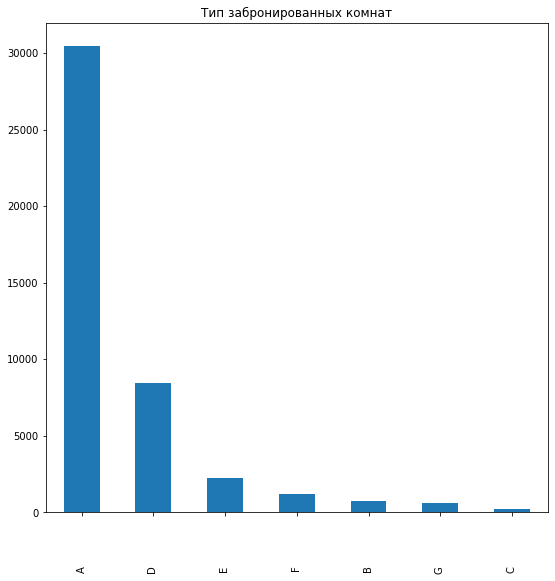

In [14]:
hotel_train['reserved_room_type'].value_counts() 
hotel_train['reserved_room_type'].value_counts().plot(kind='bar', figsize=(9, 9))
plt.title('Тип забронированных комнат')

вывод:В датафреймах hotel_train и hotel_test содержатся одинаковые столбцы, в которых имеются категориальные и количественные даные. В каждом фрейме содержится по 25 столбцов.
в таблицах содержится 25 столбцов, тип данных столбцов - float64(4), int64(15), object(6). Тип данных float64 необходимо заменить на int64;
дубликаты отсутсвуют;
пропуски не обнаружены;
данные распределены нормально, выбросы не обнаружены. Так, в столбце lead_time содержится количество дней между датой бронирования и датой прибытияминимальное, при этом минимальное значение 0, а максимальное 374, что вполне может быть - бронирование и заселение день в день, и бронирование более чем за год;
в столбце reserved_room_type содержится тип забронированной комнаты, данные соответствуют условиям задачи;
в обучающей выборке содержатся данные за 2015-2016 год, а в тестовой за 2017 год;
больше всего заездов в октябре, сентябре и августе, меньше всего в январе., феврале, марте;
25% клиетов отменяют бронь или не заезжают в номер;
77% из всех забронированных комнатах составляеют номера категории А (самые дорогие);
в основном данные коррелируют слабо между собой.

### Шаг 2. Предобработка и исследовательский анализ данных

В столбцах lead_time, adults, children, babies тип данных float64, заменим на int64.

In [15]:
hotel_train, hotel_test = hotel_train, hotel_test.astype(
    {'lead_time': 'int64', 'adults': 'int64', 'children':'int64',
     'babies': 'int64'}    
)

hotel_train.info()
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43852 entries, 0 to 65228
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     43852 non-null  int64  
 1   lead_time                       43852 non-null  float64
 2   arrival_date_year               43852 non-null  int64  
 3   arrival_date_month              43852 non-null  object 
 4   arrival_date_week_number        43852 non-null  int64  
 5   arrival_date_day_of_month       43852 non-null  int64  
 6   stays_in_weekend_nights         43852 non-null  int64  
 7   stays_in_week_nights            43852 non-null  int64  
 8   adults                          43852 non-null  float64
 9   children                        43852 non-null  float64
 10  babies                          43852 non-null  float64
 11  meal                            43852 non-null  object 
 12  country                         

Расчитаем прибыль отеля до внедрения машинного обучения. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Удалим пробелы в строках в столбце reserved_room_type и meal.

Удалим столбцы id

In [16]:
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip() 
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip() 

hotel_train['meal'] = hotel_train['meal'].str.strip() 
hotel_test['meal'] = hotel_test['meal'].str.strip() 


In [17]:
hotel_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,...,0,0,0,A,0,0,Transient,0,0,1
1,0,14.0,2015,July,27,1,0,2,2.0,0.0,...,0,0,0,A,0,0,Transient,0,1,2
2,0,0.0,2015,July,27,1,0,2,2.0,0.0,...,0,0,0,C,0,0,Transient,0,0,2
3,0,9.0,2015,July,27,1,0,2,2.0,0.0,...,0,0,0,C,0,0,Transient,0,1,2
4,1,85.0,2015,July,27,1,0,3,2.0,0.0,...,0,0,0,A,0,0,Transient,0,1,3


Создадим копию hotel_test

Оставим те столбцы, которые пригодятся для расчета прибыли

In [18]:
hotel_profit = hotel_test.copy(deep=True)

hotel_profit = hotel_profit[['is_canceled', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 
                             'arrival_date_day_of_month', 'reserved_room_type', 'total_nights']]
hotel_profit.head()

,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights
0,1,2017,January,1,1,A,1
1,1,2017,January,1,1,A,4
3,1,2017,January,1,1,A,4
4,1,2017,January,1,1,A,7
5,1,2017,January,1,1,A,7


Создаем функцию для сезонного коэффицента 

Создаем функцию для определения стоимости номера 

Создаем функцию для определения стоимости обслуживания номера 

создаем функцию для подсчета прибыли с каждого клиента

In [19]:

def coef(row):
    arrival_date_month = row['arrival_date_month']
    if arrival_date_month == 'December' or arrival_date_month == 'January' or arrival_date_month == 'February':
        return 1.0
    if arrival_date_month == 'June' or arrival_date_month == 'July' or arrival_date_month =='August':
        return 1.4
    else:
        return 1.2

    
def price_room(row):
    reserved_room_type = row['reserved_room_type']
    if reserved_room_type == 'A':
        return 1000 
    elif reserved_room_type == 'B':
        return 800
    elif reserved_room_type == 'C':
        return 600
    elif reserved_room_type == 'D':
        return 550
    elif reserved_room_type == 'E':
        return 500
    elif reserved_room_type == 'F':
        return 450
    else: 
        return 350

def price_service(row):
    reserved_room_type = row['reserved_room_type']
    if reserved_room_type == 'A':
        return 400 
    elif reserved_room_type == 'B' or reserved_room_type == 'C':
        return 350
    else: 
        return 150
    

def profit(row):
    if row['is_canceled'] == 0:
        if row['total_nights'] > 2: 
            return row['price_room'] * row['seas_coef'] * row['total_nights'] - row['price_service'] - int(row['total_nights']/2)*row['price_service']
        else:
            return row['price_room'] * row['seas_coef'] * row['total_nights'] - row['price_service']
    else:
        return - (row['price_room'] * row['seas_coef']+ row['price_service'])

Применяем функции

In [20]:
hotel_profit['seas_coef'] = hotel_profit.apply(coef, axis=1)
hotel_profit['price_room'] = hotel_profit.apply(price_room, axis=1)
hotel_profit['price_service'] = hotel_profit.apply(price_service, axis=1)
hotel_profit['profit'] = hotel_profit.apply(profit, axis=1)

Проверяем применение функций

In [21]:
display(hotel_profit['seas_coef'].value_counts().to_frame())
display(hotel_profit['price_room'].value_counts().to_frame())
display(hotel_profit['price_service'].value_counts().to_frame())
print('Суммарна прибыль отеля до внедрения депозитов', hotel_profit['profit'].sum())

,seas_coef
1.2,10316
1.4,9243
1.0,5136


,price_room
1000,16642
550,5432
500,1490
450,488
350,272
600,194
800,177


,price_service
400,16642
150,7682
350,371


Суммарна прибыль отеля до внедрения депозитов 33728180.0


### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Создадим валиадционную, тренировочную и тестовую выборки

Сеть отелей «Как в гостях» добавила на свой сайт новую услугу - бронирование номеров без предоплаты. Однако если клиент отменял бронирование (а таких 37%), то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента. Компания хочет защить себя от таких убытков. В данной работе мы будем учитывать убыток только ввиде разового обслуживания.

Наша задача: на основе тренировочных данных предсказать на тестовых данных отказ клиента от брони. Тем клиентам, кому мы предсказали высокую вероятность отказа от брони выставляется счет на оплату 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь. Модель может допустить ошибки. Они могут быть:

FP - мы забронировали номер Надежному клиенту с внесением депозита (Надежный клиент - это клиент, уверенный в своем выборе, то есть не будет изменять параметры бронирования и уверен, что его поездка состоится, и он не планирует отменять бронь). В этом случае мы предполагаем, что предложение Надежному клиенту о внесении депозита не повлечет за собой его отказ от услуг бронирования номера. Так как, если его поездка состоится - он ничего не потеряет.
FN - мы забронировали номер без внесения депозита Ненадежному клиенту (Ненадежный клиент - это клиент, который не уверен, что его поездка состоится, или он бронирует несколько номеров в разных гостиницах, чтобы выбрать в последствии один из них, ввиду новых условий, открывшихся для него). В этом случае мы терпим убыток в размере суммы разового обслуживания.
Верные предсказания:

TP - истинно-положительные - мы забронировали номер Ненадежному клиенту с выставлением счета на оплату 80% от стоимости номера за одни сутки и затрат на разовую уборку. В этом случае, если клиент откажется - у нас будет убыткок в размере: 20% от стоимости номера за одни сутки (с учетом сезонного коэффицента)+ уборка этого номера.
TN - истинно-отрицательные - мы забронировали номер Надежному клиенту без выставления счета на оплату. В этом случае мы ничего не теряем, так как Надежный клиент воспользуется забронированным номером с высокой вероятностью.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Рассмотрим два варианта рассчета экономической эффективности системы прогнозирования(ML):

Положительный - предложение внесения депозита не влияет на отток клиентов.
Отрицательный - предложение внесения депозита влечёт отток 75% клиентов.

### Шаг 4. Разработка модели ML

создадим тестовою и тренировочную выборки

In [22]:
features_train = hotel_train.drop(['is_canceled'], axis=1)
target_train = hotel_train['is_canceled']

features_test = hotel_test.drop(['is_canceled'], axis=1)
target_test = hotel_test['is_canceled']

In [23]:
print(features_train.shape,sep='')
print(features_test.shape,sep='')
print(target_train.shape,sep='')
print(target_test.shape,sep='')

(43852, 23)
(24695, 23)
(43852,)
(24695,)


посмотрим дисбаланс

<AxesSubplot:ylabel='Frequency'>

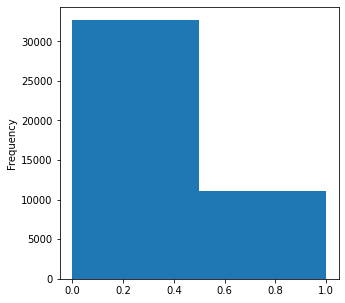

In [24]:
target_train.plot(kind ='hist', bins=2, figsize=(5,5))

Преобразуем категориальный признак 'country' техникой TargetEncoder()

In [25]:
target_encoder = TargetEncoder() 
target_encoder.fit(features_train['country'], target_train)
features_train['country'] = target_encoder.transform(features_train['country'], target_train)
features_test['country'] = target_encoder.transform(features_test['country'], target_test)

Масштабируем численные признаки

In [26]:
ohe = ['arrival_date_month', 'meal', 'distribution_channel', 'reserved_room_type', 'customer_type']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(features_train[ohe])
features_train_ohe = pd.DataFrame(encoder.transform(features_train[ohe]), columns = encoder.get_feature_names(ohe))
features_test_ohe = pd.DataFrame(encoder.transform(features_test[ohe]), columns = encoder.get_feature_names(ohe))

Масштабируем численные признаки

In [27]:
numeric = ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights',
           'stays_in_week_nights', 'adults', 'children', 'babies','previous_cancellations', 'previous_bookings_not_canceled',
           'booking_changes', 'days_in_waiting_list','required_car_parking_spaces', 'total_of_special_requests', 'total_nights']

In [28]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [29]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [30]:
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(features_train)

OneHotEncoder(handle_unknown='ignore')

In [31]:
enc.transform(features_train)
enc.transform(features_test)

<24695x819 sparse matrix of type '<class 'numpy.float64'>'
	with 543187 stored elements in Compressed Sparse Row format>

In [32]:
features_train = features_train.drop(['arrival_date_month', 'meal', 'distribution_channel', 'reserved_room_type', 'customer_type'], axis=1)
features_test = features_test.drop(['arrival_date_month', 'meal', 'distribution_channel', 'reserved_room_type', 'customer_type'], axis=1)

In [33]:
features_train = pd.concat([features_train_ohe.reset_index(drop=True), features_train.reset_index(drop=True)], axis=1, ignore_index=False)
features_test = pd.concat([features_test_ohe.reset_index(drop=True), features_test.reset_index(drop=True)], axis=1, ignore_index=False)

модель будем оценивать по f1 мере т.к. она является достаточно надежной при проверки модели.

Если модель всегда предсказывает «положительный исход», recall будет высоким
напротив, если модель никогда не предсказывает «положительный исход», precision будет высокой.
Поэтому у нас будут метрики, которые указывают на то, что наша модель эффективна, когда она, наоборот, более наивна, чем разумна.

существует метрика, объединяющая precision и recall: F1 Score.

Оценка F1 обеспечивает хорошую оценку производительности нашей модели.

напишем функцию для изучия полноты, точности и F1-меры

In [ ]:
best_DT = None
final_score_best_DT = 0
best_depth_DT = 0
leaves = 0
for depth in tqdm(range(2,52)):
    for leaf in range(1,11):
        DT = DecisionTreeClassifier(random_state = 12345, max_depth = depth,min_samples_leaf=leaf)
        DT.fit(features_train,target_train)
        scores = cross_val_score(DT, features_train, target_train, scoring='f1')
        final_score = sum(scores) / len(scores)      
        if final_score > final_score_best_DT:
            final_score_best_DT = final_score
            best_depth_DT = depth
            best_DT = DT
            leaves = leaf
            
prediction_test_DT = best_DT.predict(features_test)        
DT_probabilities = best_DT.predict_proba(features_test)[:, 1]
auc_roc_DT = roc_auc_score(target_test, DT_probabilities)


print('AUC-ROC',auc_roc_DT)
print("лучшая модель c кросс валидацией",final_score_best_DT)
print('лучшая модель с параметрами:', 'глубина-',best_depth_DT,'кол-во листьев:',leaves)

 20%|██        | 10/50 [01:14<06:20,  9.51s/it]

In [35]:
best_RF = None
final_score_best_RF=0
best_est_RF = 0
best_depth_RF = 0
for est in tqdm(range(10,150,20)):
    for depth in range(2,25):
        RF = RandomForestClassifier(random_state = 12345,n_estimators = est, max_depth = depth)
        RF.fit(features_train,target_train)
        scores = cross_val_score(RF, features_train, target_train,scoring='f1')
        final_score = sum(scores) / len(scores)
        if final_score > final_score_best_RF:
            final_score_best_RF = final_score
            best_RF = RF
            best_depth_RF = depth
            best_est_RF = est

            
prediction_test_RF = best_RF.predict(features_test)        
RF_probabilities = best_RF.predict_proba(features_test)[:, 1]
auc_roc_RF = roc_auc_score(target_test, RF_probabilities)

print('AUC-ROC',auc_roc_RF)
print("лучшая модель по кросс валидации",final_score_best_RF)
print('лучшая модель с параметрами:', 'глубина-',best_depth_RF,'','количество ветвей-',best_est_RF)

100%|██████████| 7/7 [23:47<00:00, 203.97s/it]

AUC-ROC 0.758910769812757
лучшая модель по кросс валидации 0.2617388046097505
лучшая модель с параметрами: глубина- 18  количество ветвей- 10


Создадим столбец с предсказаниями в hotel_profit, выбираем предскеазания модели RandomForest т.к. эта модели меет наибольшую метрику f1

In [42]:
predict = prediction_test_RF.astype('int64')
hotel_profit['predict'] = prediction_test_RF

функция для подсчета прибыли с каждого клиента после внедрения модели

In [45]:
def profit_after_ml(row):
    if row['is_canceled'] == 0 and row['predict'] == 1:
        if row['total_nights'] > 2: 
            return row['price_room'] * row['seas_coef'] * row['total_nights'] - row['price_service'] - int(row['total_nights']/2)*row['price_service']
        else:
            return row['price_room'] * row['seas_coef'] * row['total_nights'] - row['price_service']
    elif row['is_canceled'] == 1 and row['predict'] == 0:   
        return - (row['price_room'] * row['seas_coef']+row['price_service'])
    elif row['is_canceled'] == 1 and row['predict'] == 1:
        return  -(row['price_room'] * row['seas_coef']  + row['price_service'])*0.2
    else:
        if row['total_nights'] > 2: 
            return row['price_room'] * row['seas_coef'] * row['total_nights'] - row['price_service'] - int(row['total_nights']/2)*row['price_service']
        else:
            return row['price_room'] * row['seas_coef'] * row['total_nights'] - row['price_service']

Применяем функцию для подсчета прибыли с каждого клиента после внедрения модели

In [46]:
hotel_profit['profit_after_ml'] = hotel_profit.apply(profit_after_ml, axis=1)
print('Суммарна прибыль отеля после внедрения депозитов', hotel_profit['profit_after_ml'].sum())
print('Разница в прибыли отеля до и после внедрения депозитов', hotel_profit['profit_after_ml'].sum() - hotel_profit['profit'].sum())

Суммарна прибыль отеля после внедрения депозитов 36651172.0
Разница в прибыли отеля до и после внедрения депозитов 2922992.0


вывод:Суммарная прибыль от внедрения ML при положительном сценарии составила 42188796, при отрицательном 37787270;
Разница в прибыли отеля до и после внедрения депозитов при положительном сценарии рублей 8460616, при отрицательном - убыток 4401526 рублей. При этом бюджет на разработку модели ML - 400000 руб.

Определим срок, за который модель окупила себя.

In [47]:
display(hotel_profit.loc[0])

is_canceled                        1
arrival_date_year               2017
arrival_date_month           January
arrival_date_week_number           1
arrival_date_day_of_month          1
reserved_room_type                 A
total_nights                       1
seas_coef                        1.0
price_room                      1000
price_service                    400
profit                       -1400.0
predict                            0
profit_after_ml              -1400.0
Name: 0, dtype: object

In [48]:
display(hotel_train['arrival_date_year'].value_counts().to_frame())
display(hotel_test['arrival_date_year'].value_counts().to_frame())

,arrival_date_year
2016,34008
2015,9844


,arrival_date_year
2017,24695


Создадим переменную payback, которая будет показывать накопленный итог прибыли от внедрения ML. Переменная index покажет нам индекс(объект) на котором произошел факт окупаемости модели.

In [49]:
profit_after_ml = list(hotel_profit['profit_after_ml'])
profit = list(hotel_profit['profit'])
budget = 400000
profit_before = 0
profit_ml_opti = 0
payback = 0
index = 0
while payback <= budget:
    profit_before += profit[index]
    profit_ml_opti += profit_after_ml[index]
    payback = profit_ml_opti - profit_before
    index += 1
    
print('Первое значение, превышающее бюджет:', payback)
print('Индекс объекта, на котором модель окупилась при положительном сценарии:', index)

Первое значение, превышающее бюджет: 400800.0
Индекс объекта, на котором модель окупилась при положительном сценарии: 1455


In [51]:
display(hotel_profit.loc[1455])

is_canceled                      1
arrival_date_year             2017
arrival_date_month            June
arrival_date_week_number        23
arrival_date_day_of_month        9
reserved_room_type               E
total_nights                     4
seas_coef                      1.4
price_room                     500
price_service                  150
profit                      -850.0
predict                          1
profit_after_ml             -170.0
Name: 1455, dtype: object

вывод:Для положительного сценария - предложение о внесениии депозита не влечет отток клиентов суммарная прибыль за весь период 18.8 млн. руб, срок окупаемости - 2 месяца 10 дней;
Для отрицательного сценария - предложение внесения депозита влечёт отток 75% клиентов, что влечет убыток 407500 рублей.

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [52]:
# Определим долю отказов от брони в зависимости от количества подтверждённых заказов у клиента 
hotel_test_previous_cancel = hotel_test.groupby('previous_cancellations')['is_canceled']\
.agg(['mean', 'count']).sort_values('mean', ascending=False)
display('Доля отказов от брони в зависимости от количества подтверждённых заказов у клиента ', hotel_test_previous_cancel)

'Доля отказов от брони в зависимости от количества подтверждённых заказов у клиента '

,mean,count
previous_cancellations,,
3,0.333333,6
0,0.316770,24472
4,0.300000,10
1,0.148148,162
2,0.137931,29
5,0.000000,1
6,0.000000,15


In [53]:
hotel_test_lead_time = hotel_test.groupby('lead_time')['is_canceled'].agg(['mean', 'count'])\
.reset_index().sort_values('lead_time', ascending=True)
display('Увеличение вероятности отказа от брони с увеличением времени между бронированием из заездом:',
        hotel_test_lead_time.head(10))
print('')
display('Значение lead_time при вероятности от отказа от брони больше 50%:', hotel_test_lead_time.query('mean > 0.5'))

'Увеличение вероятности отказа от брони с увеличением времени между бронированием из заездом:'

,lead_time,mean,count
0,0,0.056502,1292
1,1,0.051282,741
2,2,0.094714,454
3,3,0.083784,370
4,4,0.077586,348
5,5,0.096273,322
6,6,0.138554,332
7,7,0.106707,328
8,8,0.200000,270
9,9,0.231441,229


'Значение lead_time при вероятности от отказа от брони больше 50%:'

,lead_time,mean,count
161,161,0.549020,51
187,187,0.567568,37
195,195,0.545455,44
210,210,0.675000,40
226,226,0.545455,22
...,...,...,...
362,365,1.000000,2
363,366,1.000000,1
365,368,0.666667,6
366,372,1.000000,2


вывод:Чем меньше срок между датой бронирования и датой заезда, тем выше вероятность того, что клиент не отменит бронь;
При бронировании менее чем за 7 дней означает, что клиент заселится с вероятностью 90%;
При количестве более 28 дней между датой бронирования и датой заезда вероятность отказа от брони составляет более 50%.

Портрет ненадежного клиента:

Бронирует номер впервые;
Бронирует за срок более 28 дней до даты заезда - вероятность отказа от брони составляет более 50%;
Бронирует за срок более 365 дней до даты заезда - вероятность отказа от брони составляет 100%.

### Шаг 6. Напишите общий вывод

данные были изучены на наличие дубликатов,пропусков,дисбаланса.

была расчитана прибыль отеля до внедрения машинного обучения.

Суммарная прибыль от внедрения ML при положительном сценарии составила 18837034, при отрицательном - имеем убыток 407500 рублей;
Перед внедрением модели необходимо провести A/B тест на отток клиентов при предложении о внесении депозита при бронировании номера. Рекомендумый отток - не более 25-30%;
Для положительного сценария - предложение о внесениии депозита не влечет отток клиентов срок окупаемости - 2 месяца 10 дней, при отрицательном - убыток;
Надежными клиентами являются:
-- бронируют номер второй и третий раз (и более); -- Самые надежные клиенты бронирует за срок менее 7 дней до даты заезда.